## 业务背景
### 用户对GPU的存在以及对运算加速的效果产生了质疑

In [78]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [71]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [72]:
!nvidia-smi

Tue Jun  9 08:34:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |  14544MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [75]:
tf.config.list_physical_devices("CPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 通过对随机大矩阵的内积以及求和，10000*10000
### 测试GPU速度

In [81]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
import sys
import tensorflow as tf
from datetime import datetime

shape = (10000, 10000)

device_name = "/gpu:0"
with tf.device(device_name):
    random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)
 
startTime = datetime.now()
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5

Shape: (10000, 10000) Device: /gpu:0
Time taken: 0:00:00.593633


### 测试CPU速度

In [82]:
device_name = "/cpu:0"
with tf.device(device_name):
    random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)
 
startTime = datetime.now()
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5

Shape: (10000, 10000) Device: /cpu:0
Time taken: 0:00:07.007780


### 写一个完整的代码来进行测试

In [49]:
shape_index = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 14000, 16000, 18000, 20000]
gpu_time = []
cpu_time = []

for i in shape_index:
    print("shape is %d"%i)
    shape = (i, i)
    
    device_name = "/gpu:0"
    with tf.device(device_name):
        random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    startTime = datetime.now()
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
            result = session.run(sum_operation)
    
    gpu_time.append((datetime.now() - startTime).total_seconds())
    
    device_name = "/cpu:0"
    with tf.device(device_name):
        random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    startTime = datetime.now()
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
            result = session.run(sum_operation)
    
    cpu_time.append((datetime.now() - startTime).total_seconds())

[0.06022, 0.061127, 0.060828, 0.063236, 0.065818, 0.04857, 0.058411, 0.06381, 0.15407, 0.355785, 0.633734, 1.042341, 1.698777, 2.649422, 3.813983, 5.24259, 6.982788, 12.058957, 19.264845, 28.291247, 41.704973, 57.250015]
[0.046954, 0.061725, 0.061712, 0.056078, 0.062949, 0.327458, 0.046454, 0.143916, 0.076921, 0.07351, 0.124287, 0.157312, 0.206742, 0.226742, 0.37517, 0.488631, 0.546155, 0.878265, 1.305315, 1.909868, 2.660149, 3.706797]


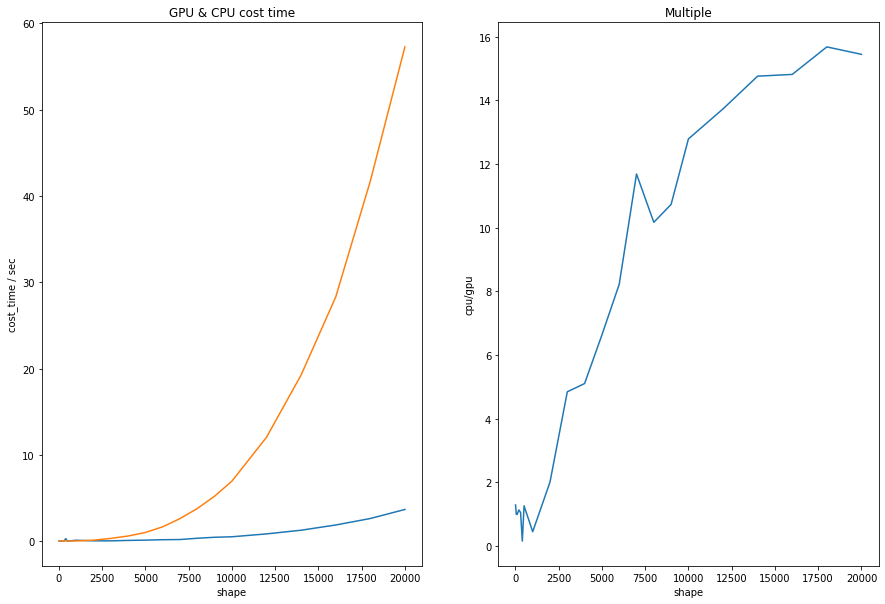

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt    
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].plot(shape_index, gpu_time)
ax[0].plot(shape_index, cpu_time)
ax[0].set_xlabel("shape")
ax[0].set_ylabel("cost_time / sec") 
ax[0].set_title("GPU & CPU cost time")

print(cpu_time)
print(gpu_time)
multiple = np.array(cpu_time) / np.array(gpu_time)
ax[1].plot(shape_index, multiple)
ax[1].set_xlabel("shape")
ax[1].set_ylabel("cpu/gpu") 
ax[1].set_title("CPU Time / GPU Time")

plt.show()

### GPU和CPU在网络上的对比

In [5]:
import tensorflow as tf
from datetime import datetime

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


startTime = datetime.now()
with tf.device('/gpu:0'):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=5)
    model.evaluate(x_test, y_test)
gpu_cost_time = datetime.now() - startTime


startTime = datetime.now()
with tf.device('/cpu:0'):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5)
    model.evaluate(x_test, y_test)
cpu_cost_time = datetime.now() - startTime

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2281 - accuracy: 0.9319
Epoch 2/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1237 - accuracy: 0.9644
Epoch 3/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1024 - accuracy: 0.9707
Epoch 4/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0859 - accuracy: 0.9756
Epoch 5/5
10000/10000 [==============================] - 0s 49us/sample - loss: 0.1086 - accuracy: 0.9725
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 20s 329us/sample - loss: 0.2288 - accuracy: 0.9316
Epoch 2/5
60000/60000 [==============================] - 19s 323us/sample - loss: 0.1248 - accuracy: 0.9633
Epoch 3/5
60000/60000 [==============================] - 19s 324us/sample - loss: 0.0999 - accuracy: 0.9714
Epoch 4/5
60000/60000 [==============================] - 19s 323us/sample - loss: 0.0862 - accuracy:

In [7]:
print('GPU Cost Time：%s, CPU Cost Time：%s' % (str(gpu_cost_time), str(cpu_cost_time)))

GPU Cost Time：0:00:20.760464, CPU Cost Time：0:01:38.578084
